# The purpose of this notebook

This is the final notebook that makes figures for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

import suppression as s
import utils

In [4]:
n_boot = 10000
np.random.seed(123)

In [5]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all'
gdf = utils.load_gaba(gaba_fn, gaba_col)

In [6]:
def categorize(df, col, values=None):
    df[col] = df[col].astype("category")
    if values is not None:
        if len(values)==len(df[col].cat.categories):
            df[col].cat.rename_categories(values, inplace=True)
            df[col].cat.reorder_categories(values.values(), inplace=True)
    return df

pop_dict = {'Amblyope':'PWA', 'Control':'NSP'}

gdf = categorize(gdf, 'Population', pop_dict)
sdf = categorize(sdf, 'Population', pop_dict)

print(gdf.Population.cat.categories)

Index(['PWA', 'NSP'], dtype='object')


In [7]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


### Set variables used for graphing

In [8]:
colors2 = {'PWA':'#1f77b4', 'NSP':'#ff7f0e'}
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
# grayscale color palette for publication
grey4 = ["#333333", "#999999", "#333333", "#999999"] # same set for PWA and NSP, NDE=light, DE=dark
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
pal4 = {}
pal4g = {}
pal4ggrey = {}
for t, c in zip(traces4, colors4):
    pal4[t] = c
for t, c in zip(traces_graph4, colors4):
    pal4g[t] = c
for t, c in zip(traces_graph4, grey4):
    pal4ggrey[t] = c
print(pal4, pal4g, sep='\n')
plot_dir = f"plots/cercor2021"

{'Amblyope-De': '#3274a1', 'Amblyope-Nde': '#72b4e1', 'Control-De': '#e1812c', 'Control-Nde': '#ffc68c'}
{'Persons with\nAmblyopia, DE': '#3274a1', 'Persons with\nAmblyopia, NDE': '#72b4e1', 'Normally-sighted\npersons, DE': '#e1812c', 'Normally-sighted\npersons, NDE': '#ffc68c'}


## Demographic stuff from KB

In [9]:
amb_data = demos[demos['group']==1].copy()
nsp_demos = demos[demos['group']==0].copy()

amb_data['motorGABA'] = pd.to_numeric(amb_data['motorGABA'].str.strip(), errors='coerce')
print("occ gaba vs IAD: ", st.spearmanr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(amb_data['motorGABA'], amb_data['iadLogMAR'], nan_policy='omit'))
print("occ gaba vs interocular acuity difference: ", st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR']))

has_motor = amb_data[~np.isnan(amb_data['motorGABA'])]

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6365654208460114, pvalue=0.014373530547495347)
motor gaba vs IAD:  SpearmanrResult(correlation=0.21276694028802262, pvalue=0.5550759959985581)
occ gaba vs interocular acuity difference:  (-0.7056578245904567, 0.004805440709063252)


#### Demographic info for controls

In [10]:
np.count_nonzero(nsp_demos.labelSex=='female')

6

In [11]:
iad_plot_df = demos.join(gdf.set_index(['subjName'])['GABA'], on=['initials'])

### Figure 5

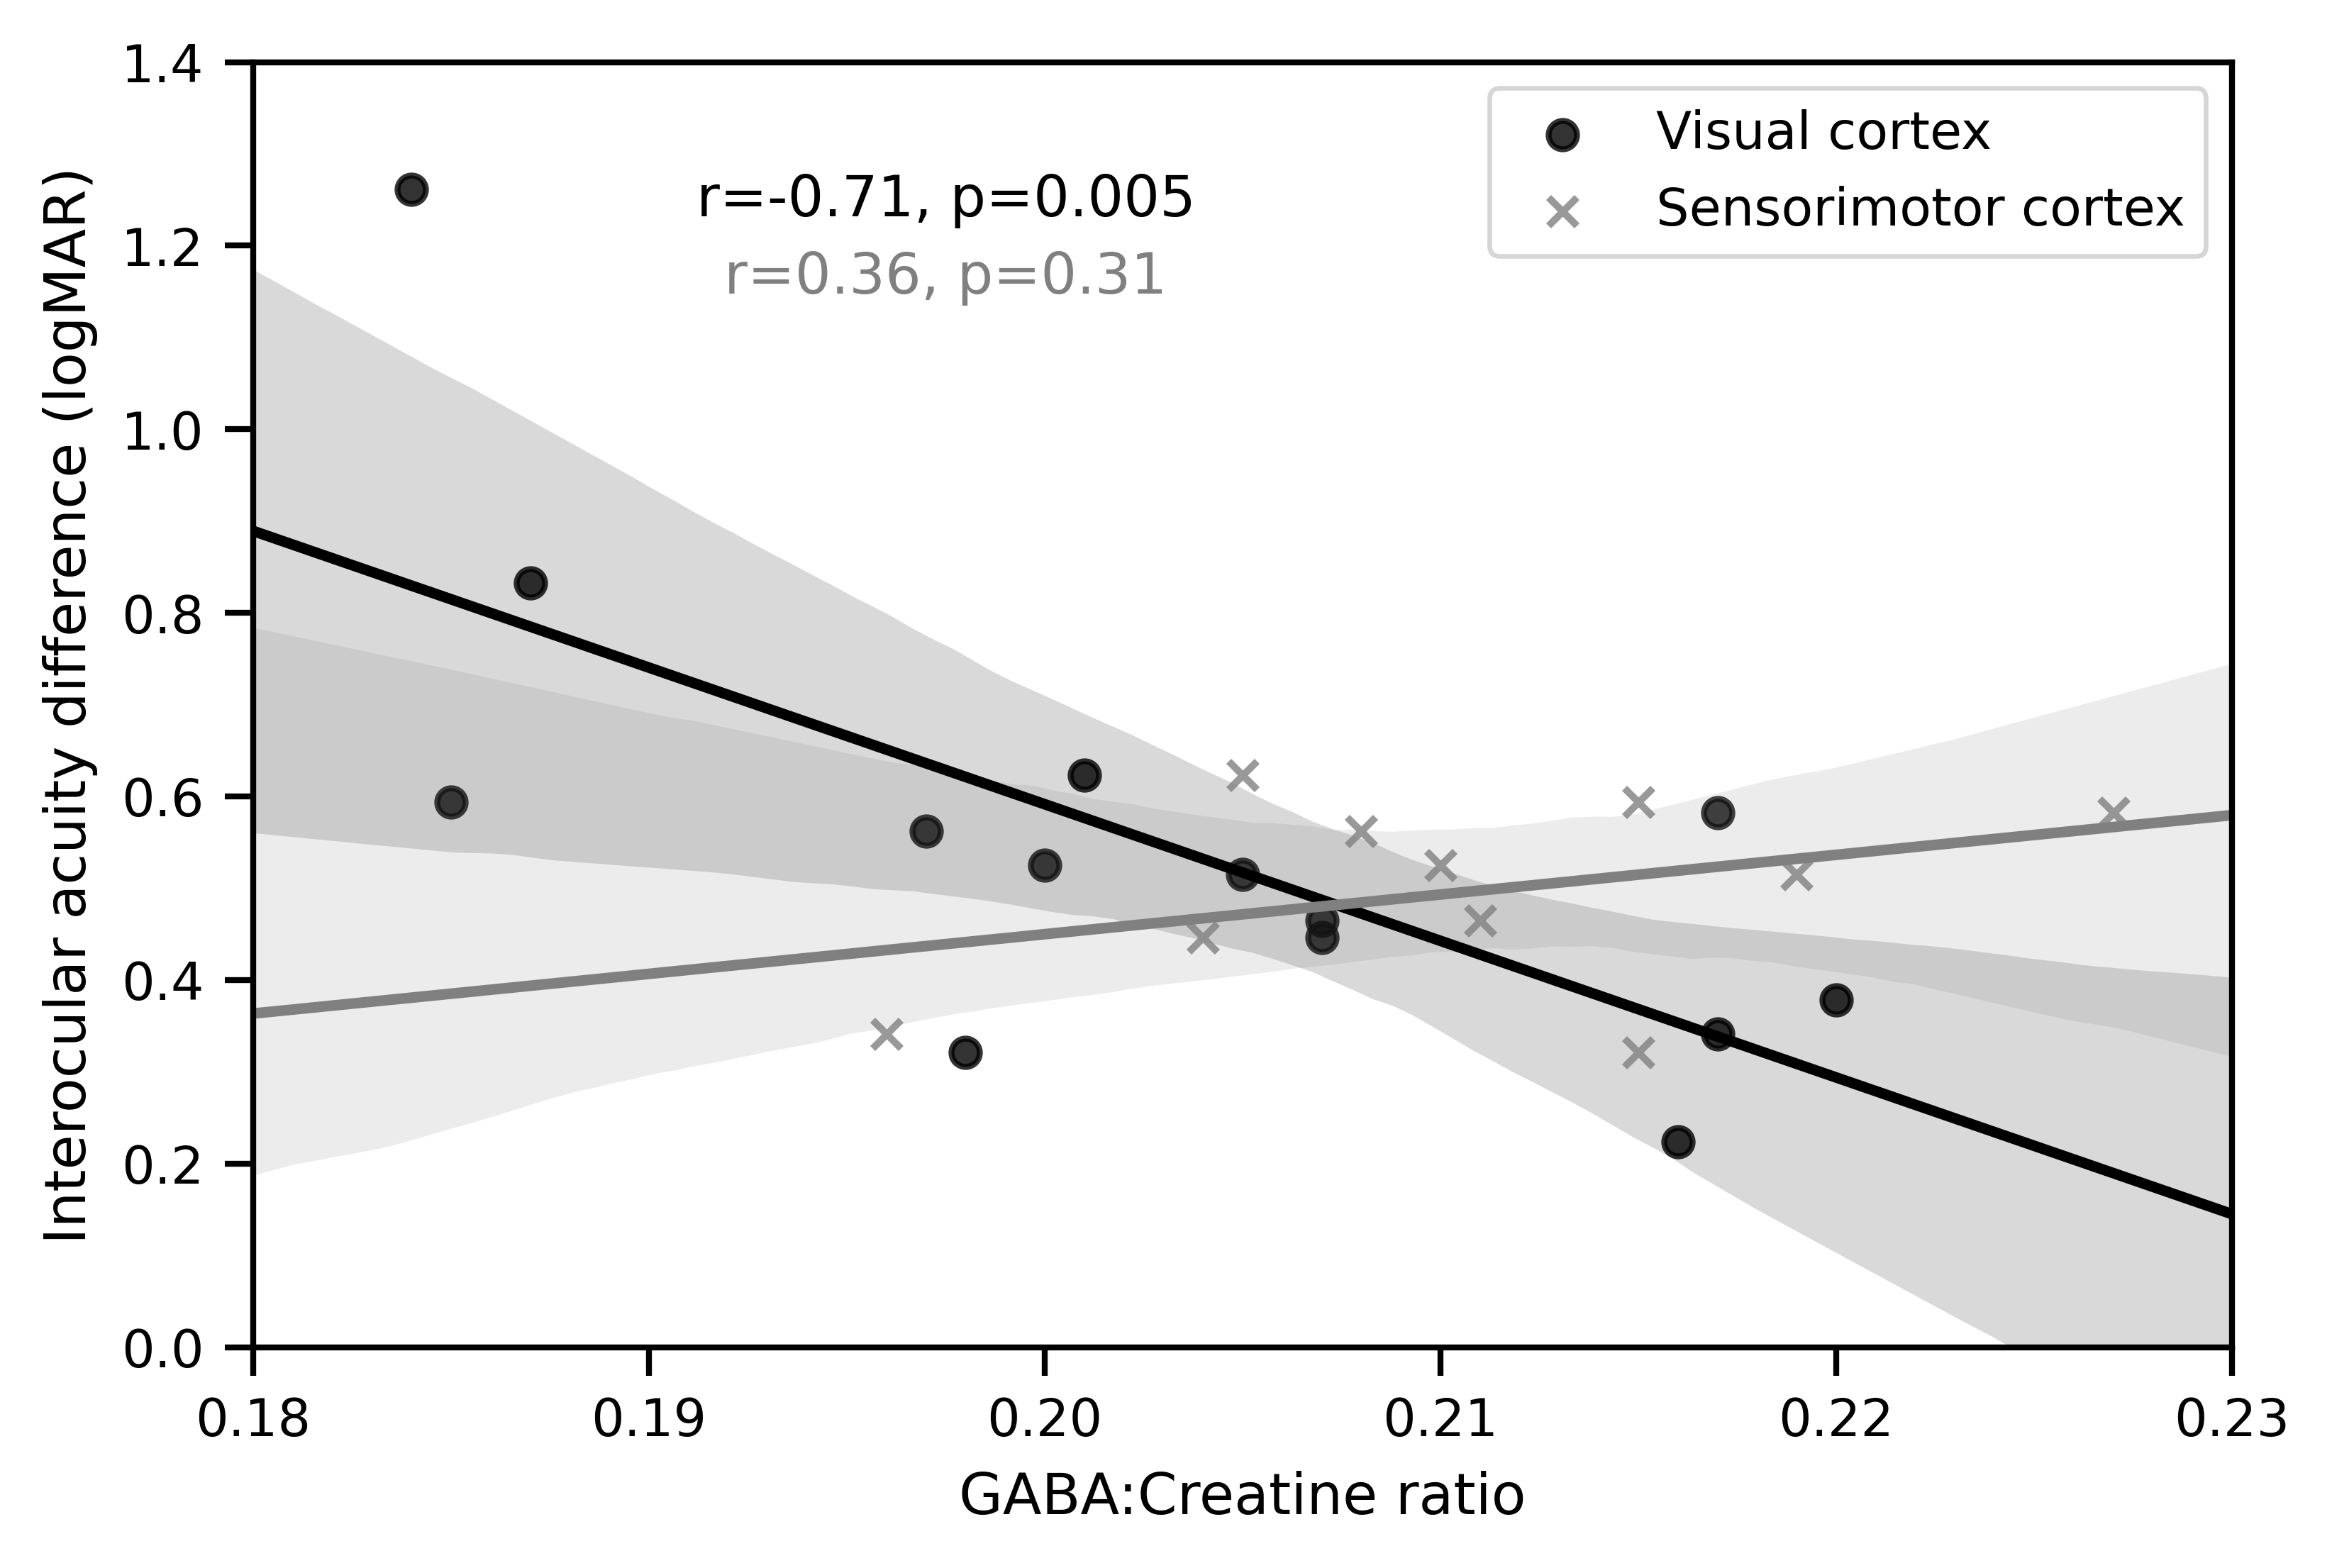

In [55]:
#with s.PdfPages(f"{plot_dir}/figure_05.pdf") as pdf:
with sns.plotting_context(context="paper", font_scale=1.0):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
    ax.set_xlim(0.18, 0.23)
    ax.set_ylim(0, 1.4)

    sns.regplot(data=amb_data, x='occGABA', y='iadLogMAR', color='black', marker='o', ax=ax, label='Visual cortex', truncate=False)
    r, p = st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR'])
    ax.text(.35, 0.88, f"r={r:.2f}, p={p:.3f}", transform=ax.transAxes, fontdict={'color': 'black'}, horizontalalignment='center')

    sns.regplot(data=amb_data, x='motorGABA', y='iadLogMAR', color='grey', marker='x', ax=ax, label='Sensorimotor cortex', truncate=False)
    r, p = st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])
    ax.text(.35, 0.82, f"r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontdict={'color': 'grey'}, horizontalalignment='center')

    ax.legend()
    ax.set_xlabel("GABA:Creatine ratio")
    ax.set_ylabel("Interocular acuity difference (logMAR)")
    fig.set_dpi(600)
    fig.savefig(f"{plot_dir}/figure_05.tif", dpi='figure')
    plt.show()
    plt.close('all')

In [13]:
st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])

(0.3602346498548901, 0.30653032721555246)

## Analyze tasks separately (before subsetting to include common subjects)

In [14]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

#### Remove AM and TT based on discussions with Kelly 12/2019.

In [15]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7154537449760946 0.48047050303580574


In [16]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                                           
           count      mean       std    min      25%    50%      75%    max
Population                                                                 
PWA         14.0  0.202929  0.012092  0.184  0.19725  0.203  0.21375  0.220
NSP         15.0  0.205800  0.009443  0.193  0.19850  0.203  0.21100  0.223

## Figure 4

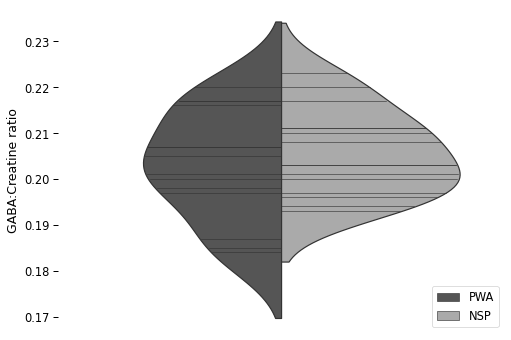

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
with sns.plotting_context(context="paper", font_scale=1.3):
    fig = plt.figure(figsize=(8,6))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gaba_df_immutable,split=True,
                        inner='stick',ax=ax,palette="gray",#colors2,
                        legend=False)
    ax.legend(loc=4)
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    sns.despine(left=True, bottom=True, right=True)
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    ax.figure.savefig(f"{plot_dir}/figure_04.eps", format="eps")
    plt.show()
    plt.close(ax.figure)
    plt.close('all')

# Select one psychophysical task's data #

In [18]:
task = 'SS' # surround suppression task
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy(deep=True) # make a deep copy

n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="PWA"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Check to see how baseline contrast discrimination thresholds look

In [19]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()
thresh_noswap = onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace','Subject'], as_index=False)['BaselineThresh'].mean().dropna()
eye_counts = thresh_noswap['Subject'].value_counts().reset_index()
nounpaired = (eye_counts[eye_counts.Subject==2])['index'].unique()
thresh_noswap_nounpaired = thresh_noswap[thresh_noswap['Subject'].isin(nounpaired)]
thresh_noswap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                              \
                      count      mean       std    min      25%     50%   
Trace                                                                     
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.2620   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.7870   
Control-De             16.0  6.309750  1.559247  4.033  5.42650  6.0295   
Control-Nde            16.0  5.921750  1.467759  3.124  5.20325  5.6900   

                               
                  75%     max  
Trace                          
Amblyope-De   6.82600   7.827  
Amblyope-Nde  7.83400  13.226  
Control-De    6.90475   9.987  
Control-Nde   6.68325   8.794

### Assign NDE/DE purely via baseline contrast discrimination

In [20]:
subs_to_swap_eyes_baselineSS = []
for gv, g in thresh_noswap_nounpaired.groupby(['Subject']):
    nde_thresh = g[g.Eye=='Nde']['BaselineThresh'].iloc[0]
    de_thresh = g[g.Eye=='De']['BaselineThresh'].iloc[0]
    diff = nde_thresh - de_thresh
    is_nsp = np.all(g['Population']=='NSP')
    if is_nsp and diff < 0:
        print(f"Participant {gv} has a lower threshold in Nde than De but is a NSP, will swap.")
        subs_to_swap_eyes_baselineSS.append(g.Subject.iloc[0])

Participant ai has a lower threshold in Nde than De but is a NSP, will swap.
Participant cr has a lower threshold in Nde than De but is a NSP, will swap.
Participant ct has a lower threshold in Nde than De but is a NSP, will swap.
Participant dl has a lower threshold in Nde than De but is a NSP, will swap.
Participant ei has a lower threshold in Nde than De but is a NSP, will swap.
Participant gm has a lower threshold in Nde than De but is a NSP, will swap.
Participant jd has a lower threshold in Nde than De but is a NSP, will swap.
Participant kw has a lower threshold in Nde than De but is a NSP, will swap.
Participant ls has a lower threshold in Nde than De but is a NSP, will swap.
Participant ms has a lower threshold in Nde than De but is a NSP, will swap.
Participant se has a lower threshold in Nde than De but is a NSP, will swap.
Participant tm has a lower threshold in Nde than De but is a NSP, will swap.
Participant yl has a lower threshold in Nde than De but is a NSP, will swap.

In [21]:
def swap_eyevars(df, subs):
    if df['Subject'] in subs: # fix here
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    # Identify which rows are of subjects that should be swapped
    # Changed 6/18/21 to include the possibility of assigning eyes based on baseline surround suppression
    subs_to_swap_eyes = subs_to_swap_eyes_baselineSS # assign NSP eyes purely based on baselineSS, disregarding swapNde_EY etc.
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    assert(np.all(rows_to_change.Population == 'NSP')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, subs=subs_to_swap_eyes, axis=1)
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

In [22]:
df_to_model_fixeyes.groupby("Trace")['BaselineThresh'].describe()

,count,mean,std,min,25%,50%,75%,max
Trace,,,,,,,,
Amblyope-De,208.0,6.170423,1.226235,4.063,5.949,6.262,6.826,7.827
Amblyope-Nde,204.0,7.228000,2.152685,4.558,5.944,6.787,7.834,13.226
Control-De,216.0,5.826167,1.357432,3.124,4.985,5.552,6.405,8.794
Control-Nde,342.0,6.174883,1.385176,4.033,5.205,5.741,6.745,9.987


### Toggle which version of the data to use, "fixed" eyes or not

In [23]:
df_to_model = df_to_model_fixeyes

### Begin grouping data into conditions to model Subject's ThreshElev as a function of MaskContrast

In [24]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

### BaselineThresh analysis before modeling

In [25]:
thresh_swap = df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Subject','Eye', 'Trace'])['BaselineThresh'].mean().reset_index()
thresh_swap = thresh_swap[(thresh_swap.Orientation=="Iso")&(thresh_swap.Presentation=='nDicho')]
eye_counts_swap = thresh_swap.Subject.value_counts()
subs_no_unpaired = eye_counts[eye_counts_swap.reset_index()['Subject']==2]['index'].unique()
print(subs_no_unpaired, len(subs_no_unpaired))

['nl' 'rn' 'ct' 'ei' 'mk' 'cr' 'es' 'jv' 'dl' 'sd' 'li' 'se' 'mv' 'mg'
 'cl' 'eg' 'ah' 'ls' 'em' 'tm' 'kw' 'am' 'gd' 'jd' 'gm' 'bi' 'yl' 'ai'
 'ms'] 29


In [26]:
thresh_swap_nounpaired = thresh_swap[thresh_swap.Subject.isin(subs_no_unpaired)]

#### Calculate differences, ratios etc for each subject

In [27]:
baseline_df_withinsubject = thresh_swap.groupby(#thresh_swap_nounpaired.groupby(
                                        ['Task', 'Orientation', 'Presentation', 'Population',
                                        'Subject']).apply(utils.get_interocular_diff, 'BaselineThresh')
baseline_df_withinsubject.rename(columns={'ValueDiff':'BaselineDiff', 'ValueRatio':'BaselineRatio'}, inplace=True)
baseline_df_withinsubject[(baseline_df_withinsubject.Population=="PWA") & (baseline_df_withinsubject.Eye=="De")]

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
166,SS,Iso,nDicho,PWA,ah,De,Amblyope-De,7.590,-3.032,0.600527
168,SS,Iso,nDicho,PWA,am,De,Amblyope-De,7.532,0.302,1.040096
170,SS,Iso,nDicho,PWA,bi,De,Amblyope-De,7.827,2.314,1.295643
172,SS,Iso,nDicho,PWA,cl,De,Amblyope-De,6.709,0.749,1.111641
174,SS,Iso,nDicho,PWA,eg,De,Amblyope-De,6.826,-0.039,0.994287
176,SS,Iso,nDicho,PWA,em,De,Amblyope-De,5.949,0.065,1.010926
178,SS,Iso,nDicho,PWA,gd,De,Amblyope-De,6.210,0.326,1.052496
180,SS,Iso,nDicho,PWA,jv,De,Amblyope-De,4.227,0.537,1.127040
182,SS,Iso,nDicho,PWA,li,De,Amblyope-De,4.063,3.253,1.800640
184,SS,Iso,nDicho,PWA,mg,De,Amblyope-De,4.174,1.480,1.354576


In [28]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject.groupby(['Population','Subject'], as_index=False)[['BaselineDiff','BaselineRatio']].mean()
baseline_df_withinsubject_diffs = categorize(baseline_df_withinsubject_diffs, 'Population', {'PWA':'PWA','NSP':'NSP'})

###  Exclude subject 'ah' based on being a HUGE outlier

In [29]:
adiff = baseline_df_withinsubject_diffs[(baseline_df_withinsubject_diffs.Population=="PWA") &
                                        (baseline_df_withinsubject_diffs.Subject!="ah")].dropna()
cdiff = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Population=="NSP"].dropna()

In [30]:
print(adiff, cdiff, sep='\n')
print("PWA NDE/DE != 1:", st.ttest_1samp(adiff['BaselineRatio'], popmean=1))
print("NSP NDE/DE != 1:", st.ttest_1samp(cdiff['BaselineRatio'], popmean=1))
print("PWA != NSP:", st.ttest_ind(adiff['BaselineRatio'], cdiff['BaselineRatio']))

   Population Subject  BaselineDiff  BaselineRatio
23        PWA      am         0.302       1.040096
24        PWA      bi         2.314       1.295643
25        PWA      cl         0.749       1.111641
26        PWA      eg        -0.039       0.994287
27        PWA      em         0.065       1.010926
28        PWA      gd         0.326       1.052496
29        PWA      jv         0.537       1.127040
30        PWA      li         3.253       1.800640
31        PWA      mg         1.480       1.354576
32        PWA      mv        -0.037       0.993814
33        PWA      rn         2.483       1.386519
34        PWA      sd         6.964       2.112105
   Population Subject  BaselineDiff  BaselineRatio
0         NSP      ai         0.043       1.006232
3         NSP      cr         0.909       1.290973
4         NSP      ct         0.163       1.018535
5         NSP      dl         0.973       1.168572
6         NSP      ei         1.473       1.295486
7         NSP      es         0

In [31]:
baseline_df_withinsubject = baseline_df_withinsubject[baseline_df_withinsubject.Subject != 'ah'].dropna()
baseline_df_withinsubject_diffs = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Subject != 'ah'].dropna()
df_to_model = df_to_model[df_to_model.Subject!='ah']

In [32]:
# Exclude those with unpaired eyes
df_to_model = df_to_model[df_to_model.Subject.isin(nounpaired)]

#### Figure 6 combined into one panel

In [33]:
baseline_df_withinsubject.Trace = baseline_df_withinsubject.Trace.astype('category')
baseline_df_withinsubject.Trace.cat.reorder_categories(traces4, inplace=True)
baseline_df_withinsubject.Trace.cat.rename_categories(traces_graph4, inplace=True)

Population
NSP    16
PWA    12
Name: Subject, dtype: int64
Population
PWA    12
NSP    16
Name: Subject, dtype: int64


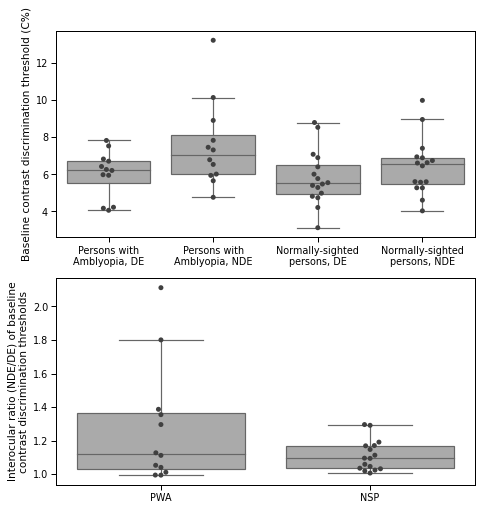

In [34]:
sns.set_context(context="paper", font_scale=1.1)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))#, gridspec_kw={"width_ratios":[2, 1]})
g = sns.boxplot(data=baseline_df_withinsubject,
                x='Trace',
                y='BaselineThresh',
                ax=ax[0],
                palette=["#aaaaaa"],
                fliersize=0) # fliersize=0 so outliers not drawn by boxplot()
g = sns.swarmplot(data=baseline_df_withinsubject,
                  x='Trace',
                  y='BaselineThresh',
                  ax=ax[0], color=".25")
g.set_xlabel('')
g.set_ylabel('Baseline contrast discrimination threshold (C%)')
print(baseline_df_withinsubject.groupby(['Population'])['Subject'].nunique())


g2 = sns.boxplot(data=baseline_df_withinsubject_diffs,
                 x='Population',
                 y='BaselineRatio',
                 ax=ax[1],
                 palette=["#aaaaaa"],
                 fliersize=0)
g2 = sns.swarmplot(data=baseline_df_withinsubject_diffs,
                   x='Population',
                   y='BaselineRatio',
                   ax=ax[1],
                   color=".25")
g2.set_xlabel('')
g2.set_ylabel('Interocular ratio (NDE/DE) of baseline\ncontrast discrimination thresholds')
plt.subplots_adjust(left=.12, right=.95, top=.95, bottom=.05, hspace=.2)
print(baseline_df_withinsubject_diffs.groupby(['Population'])['Subject'].nunique())

fig.savefig(f"{plot_dir}/figure_06.eps")
plt.show()
plt.close('all')

In [35]:
def test_eye_diffs(g, col):
    ndes = g[g.Eye=='Nde'][['Subject',col]].sort_values(by=['Subject'])
    des = g[g.Eye=='De'][['Subject',col]].sort_values(by=['Subject'])
    diffs = g.groupby(['Subject']).apply(utils.get_interocular_diff, col).drop_duplicates(subset=['Subject','ValueRatio'])
    assert(ndes.Subject.array.equals(des.Subject.array))
    res = st.ttest_1samp(diffs['ValueRatio'], popmean=1)
    print(f"N=({len(ndes)}, {len(des)}, mean: {diffs['ValueRatio'].mean():.2f})\n1sample (NDE/DE): t={res.statistic:.2f}, p={res.pvalue:.2f}")
    return res, diffs

for gv, g in baseline_df_withinsubject.groupby(['Task','Orientation','Presentation']):
    print(gv)
    for gv2, g2 in g.groupby(['Population']):
        print(gv2)
        res, diffs = test_eye_diffs(g2, "BaselineThresh")

('SS', 'Iso', 'nDicho')
NSP
N=(16, 16, mean: 1.11)
1sample (NDE/DE): t=4.83, p=0.00
PWA
N=(12, 12, mean: 1.27)
1sample (NDE/DE): t=2.68, p=0.02


### GABA vs baseline contrast threshold

In [36]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'measure'])['value'].describe(percentiles=[.5])

count      mean  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
     Iso         nDicho       NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   

                                                                  std    min  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
     Iso         nDicho       NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   

                                                                50%     max  
Task Orientation Presentation Population Eye measure                         
SS   Cross       nDicho       NSP        De  BaselineThresh  5.5150   8.794  
                                         Nde BaselineThresh  6.5345   9.987  
                              PWA        De  BaselineThresh  6.2360   7.827  
                                         Nde BaselineThresh  7.0515  13.226  
                 nMono        NSP        De  BaselineThresh  5.5150   8.794  
                                         Nde BaselineThresh  6.5345   9.987  
                              PWA        De  BaselineThresh  6.2360   7.827  
                                         Nde BaselineThresh  7.0515  13.226  
     Iso         nDicho       NSP        De  BaselineThresh  5.5150   8.794  
                                         Nde BaselineThresh  6.5345   9.987  
                              PWA        De  BaselineThresh  6.2360   7.827  
                                         Nde BaselineThresh  7.0515  13.226  
                 nMono        NSP        De  BaselineThresh  5.5150   8.794  
         

#### Drop subjects without GABA

In [37]:
simple_bg_df_nonan = simple_bg_df[~np.isnan(simple_bg_df.GABA)]
simple_bg_df_nonan_onecond = (simple_bg_df_nonan[(simple_bg_df_nonan['Presentation']=='nDicho') & (simple_bg_df_nonan['Orientation']=='Iso')])

### Figure 7

In [38]:
%%time
bg_groups = simple_bg_df_nonan.groupby(['Task','Orientation','Presentation','measure'])
i = 0 # only do the first group since they're all the same
for gv, gr in bg_groups:
    if i==0:
        g = s.gaba_vs_psychophys_plot(gv, gr, legend=False,
                    log=True, ylim=(2.5, 16), truncate=False,
                    col="Population", col_order=["PWA", "NSP"], hue="Trace",
                    sharex=False, sharey=False,
                    palette=pal4ggrey,
                    n_boot=n_boot, legend_img=False,
                    markers=['o','d','o','d'],
                    aspect=1)
        g.set_titles("")
        g.fig.subplots_adjust(left=.1, right=.95, bottom=0.1, wspace=0.15)
        g.fig.set_dpi(600)
        g.fig.set_size_inches((7,3.75))
        g.fig.savefig(f"{plot_dir}/figure_07.tif", dpi="figure")
        plt.close('all')
        i = 1

('SS', 'Cross', 'nDicho', 'BaselineThresh')
nDicho

Percentiles for individual eye correlations:
Amb DE 
Observed value of -0.405 is greater than 0.147 of bootstrap distribution, corresponding to p=0.29.
Amb NDE 
Observed value of -0.214 is greater than 0.290 of bootstrap distribution, corresponding to p=0.58.
Con DE 
Observed value of 0.249 is greater than 0.810 of bootstrap distribution, corresponding to p=0.38.
Con NDE 
Observed value of 0.218 is greater than 0.772 of bootstrap distribution, corresponding to p=0.46.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of 0.190 is greater than 0.623 of bootstrap distribution, corresponding to p=0.75.
Con NDE vs DE 
Observed value of -0.031 is greater than 0.464 of bootstrap distribution, corresponding to p=0.93.
Pop Amb vs Con 
Observed value of 0.221 is greater than 0.634 of bootstrap distribution, corresponding to p=0.73.
[0.295 0.58  0.381 0.457], [0.753 0.928 0.731]

CPU times: user 1min 43s, sys: 1.05 s, tota

## Plot and model the suppression data (RelMaskContrast vs ThreshElev)

In [39]:
sns.relplot(data=df_to_model, x="MaskContrast", y="ThreshElev", hue="Trace",
                        row="Orientation",
                        #col="Population", col_order=["PWA", "NSP"],
                        col="Presentation", col_order=["nMono", "nDicho"],
                        palette=pal4, style="Eye", markers=['o','d'],
                        height=4.5, aspect=1.3)\
    .map(plt.axhline, y=1, linestyle='dotted', color='black')\
    .set(ylabel="Threshold Elevation")\
    .set(xlabel='Surround Contrast (C%)')
plt.close('all')

In [40]:
sns.relplot(data=df_to_model, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        row="Orientation",
                        #col="Population", col_order=["PWA", "NSP"],
                        col="Presentation", col_order=["nMono", "nDicho"],
                        palette=pal4, style="Eye", markers=['o','d'],
                        height=4.5, aspect=1.3)\
.map(plt.axhline, y=1, linestyle='dotted', color='black')\
.map(plt.axvline, x=2, linestyle='dotted', color='grey')\
.map(plt.axvline, x=5, linestyle='dotted', color='grey')\
.map(plt.axvline, x=10, linestyle='dotted', color='grey')\
.set(ylabel="Threshold Elevation")\
.set(xlabel='Relative surround contrast\n (multiples of baseline)')
plt.close('all')

## Pick critical value and observations closest to that

In [41]:
def closest_obs(df, col, to):
    co = (df.iloc[np.argmin(np.abs(df[col] - to))])
    return co

def annotate(data, field="hue", pos=(.05, .7), **kws):
    ax=plt.gca()
    for (i, (gv, g)) in enumerate(data.groupby(field)):
        pos_this=(pos[0], pos[1]+(.05*i))
        annotation = f"{gv} n={len(g)}"
        ax.text(*pos_this, annotation, transform=ax.transAxes)

**Analysis at RelMaskContrast=5**



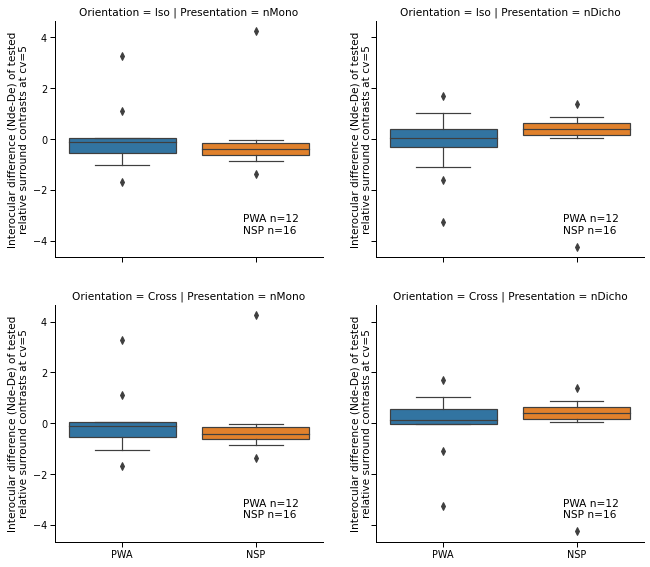

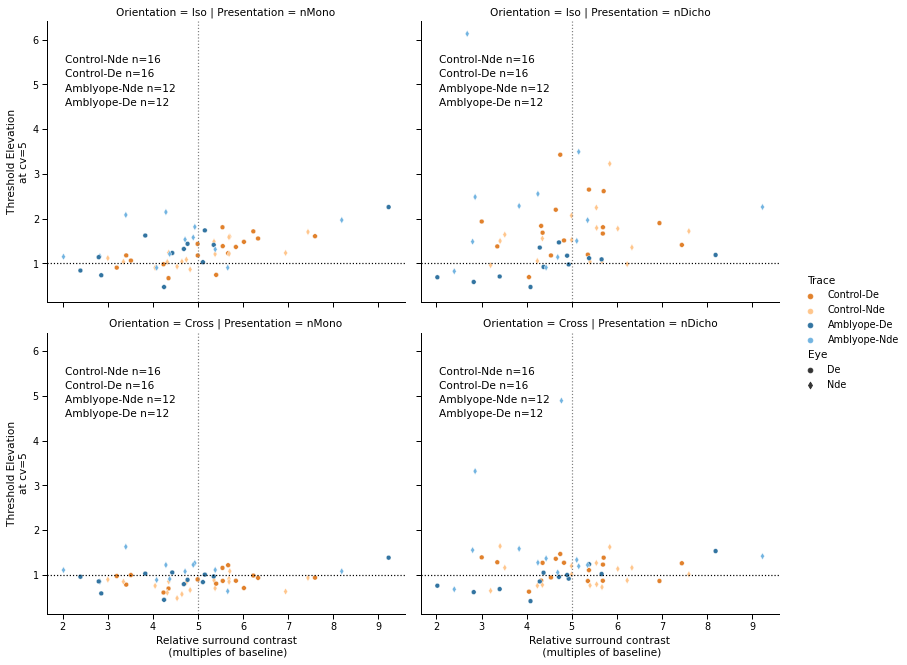

In [42]:
cv = 5
print(f"**Analysis at RelMaskContrast={cv}**\n")
final_obs = df_to_model.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)
sub_groups = final_obs.groupby(['Task','Orientation','Presentation','Population','Subject'], as_index=False)
xdiffs = sub_groups.apply(utils.get_interocular_diff, "RelMaskContrast").dropna().drop_duplicates(['Task','Orientation','Presentation','Subject','ValueDiff'])

g1 = sns.catplot(kind='box', data=xdiffs, x='Population', y='ValueDiff', order=["PWA", "NSP"],
            row="Orientation", row_order=["Iso", "Cross"],
            col="Presentation", col_order=["nMono", "nDicho"],
            height=4, aspect=1.1,
            palette=colors2)\
    .map_dataframe(annotate, field='Population', pos=(.7, .1))\
    .set(ylabel=f"Interocular difference (Nde-De) of tested\nrelative surround contrasts at cv={cv}")
g1.fig.subplots_adjust(wspace=.2, hspace=.2)
plt.show()
sns.relplot(data=final_obs, x="RelMaskContrast", y="ThreshElev", hue="Trace",
            row="Orientation", row_order=["Iso", "Cross"],
            col="Presentation", col_order=["nMono", "nDicho"],
            palette=pal4, style="Eye", markers=['o','d'],
            height=4.5, aspect=1.2)\
.map_dataframe(annotate)\
.map(plt.axhline, y=1, linestyle='dotted', color='black')\
.map(plt.axvline, x=cv, linestyle='dotted', color='grey')\
.set(ylabel=f"Threshold Elevation\nat cv={cv}")\
.set(xlabel='Relative surround contrast\n (multiples of baseline)')
plt.show()
plt.close('all')

In [43]:
final_obs.groupby(['Task','Orientation','Presentation','Population','Eye'])[['RelMaskContrast','ThreshElev']].describe(percentiles=[.5])

RelMaskContrast            \
                                                       count      mean   
Task Orientation Presentation Population Eye                             
SS   Cross       nDicho       NSP        De             16.0  5.001938   
                                         Nde            16.0  5.180063   
                              PWA        De             12.0  4.564167   
                                         Nde            12.0  4.572083   
                 nMono        NSP        De             16.0  5.180063   
                                         Nde            16.0  5.001938   
                              PWA        De             12.0  4.572083   
                                         Nde            12.0  4.564167   
     Iso         nDicho       NSP        De             16.0  5.001938   
                                         Nde            16.0  5.180063   
                              PWA        De             12.0  4.564167   
                                         Nde            12.0  4.398167   
                 nMono        NSP        De             16.0  5.180063   
                                         Nde            16.0  5.001938   
                              PWA        De             12.0  4.572083   
                                         Nde            12.0  4.564167   

                                                                              \
                                                   std    min     50%    max   
Task Orientation Presentation Population Eye                                   
SS   Cross       nDicho       NSP        De   1.164983  3.004  4.7855  7.438   
                                         Nde  1.194950  3.201  5.4740  7.594   
                              PWA        De   1.550175  2.021  4.5445  8.186   
                                         Nde  1.768702  2.396  4.5595  9.225   
                 nMono        NSP        De   1.194950  3.201  5.4740  7.594   
                                         Nde  1.164983  3.004  4.7855  7.438   
                              PWA        De   1.768702  2.396  4.5595  9.225   
                                         Nde  1.550175  2.021  4.5445  8.186   
     Iso         nDicho       NSP        De   1.164983  3.004  4.7855  7.438   
                                         Nde  1.194950  3.201  5.4740  7.594   
                              PWA        De   1.550175  2.021  4.5445  8.186   
                                         Nde  1.848288  2.396  4.3400  9.225   
                 nMono        NSP        De   1.194950  3.201  5.4740  7.594   
                                         Nde  1.164983  3.004  4.7855  7.438   
                              PWA        De   1.768702  2.396  4.5595  9.225   
                                         Nde  1.550175  2.021  4.5445  8.186   

                                             ThreshElev                      \
                                                  count      mean       std   
Task Orientation Presentation Population Eye                                  
SS   Cross       nDicho       NSP        De        16.0  1.130500  0.252378   
                                         Nde       16.0  1.035813  0.303820   
                              PWA        De        12.0  0.921167  0.293242   
                                         Nde       12.0  1.742000  1.178050   
                 nMono        NSP        De        16.0  0.897125  0.159301   
                                         Nde       16.0  0.782062  0.159986   
                              PWA        De        12.0  0.902167  0.237104   
                                         Nde       12.0  1.084417  0.251255   
     Iso         nDicho       NSP        De        16.0  1.818750  0.664917   
                                         Nde       16.0  1.593687  0.585806   
                              PWA        De        12.0  0.979167  0.311035   
           

### Table 3: Psychophysical results (t-tests of relative threshold in NDE vs DE - 1samp of ratio)

In [44]:
for gv, g in final_obs.groupby(['Task','Orientation','Presentation']):
    print(gv)
    for gv2, g2 in g.groupby(['Population']):
        print(gv2)
        res, diffs = test_eye_diffs(g2, "ThreshElev")

('SS', 'Cross', 'nDicho')
NSP
N=(16, 16, mean: 0.93)
1sample (NDE/DE): t=-1.45, p=0.17
PWA
N=(12, 12, mean: 2.17)
1sample (NDE/DE): t=2.38, p=0.04
('SS', 'Cross', 'nMono')
NSP
N=(16, 16, mean: 0.88)
1sample (NDE/DE): t=-2.48, p=0.03
PWA
N=(12, 12, mean: 1.28)
1sample (NDE/DE): t=2.35, p=0.04
('SS', 'Iso', 'nDicho')
NSP
N=(16, 16, mean: 0.91)
1sample (NDE/DE): t=-1.40, p=0.18
PWA
N=(12, 12, mean: 2.49)
1sample (NDE/DE): t=3.42, p=0.01
('SS', 'Iso', 'nMono')
NSP
N=(16, 16, mean: 1.01)
1sample (NDE/DE): t=0.11, p=0.92
PWA
N=(12, 12, mean: 1.26)
1sample (NDE/DE): t=2.21, p=0.05


### Make Figure 3, the modeling example

In [45]:
onecond = df_to_model[(df_to_model.Orientation=="Iso") & (df_to_model.Presentation=="nDicho")]
ns_onecond = onecond.groupby(['Task','Orientation','Presentation','Population','Eye','Trace'])['Subject'].nunique().reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 8), dpi=300)

sns.scatterplot(data=onecond, ax=ax1, x="MaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend=False)
ax1.set(ylabel="Relative contrast\ndiscrimination threshold")
ax1.set(xlabel='Surround Contrast')
ax1.axhline(y=1, linestyle='dotted', color='grey')

sns.scatterplot(data=onecond, ax=ax2, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend=False)
ax2.set(ylabel="Relative contrast\ndiscrimination threshold")
ax2.set(xlabel='Relative surround contrast\n (multiples of baseline)')
ax2.axhline(y=1, linestyle='dotted', color='grey')
ax2.axvline(x=5, linestyle='dotted', color='black')

final_obs_onecond = onecond.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)

sns.scatterplot(data=final_obs_onecond, ax=ax3, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend="brief")
ax3.legend_.set_visible(False)
ax3.set(xlim=ax2.get_xlim())
ax3.set(ylabel="Relative contrast\ndiscrimination threshold")
ax3.set(xlabel='Relative surround contrast\n (multiples of baseline)')
ax3.axhline(y=1, linestyle='dotted', color='grey')
ax3.axvline(x=5, linestyle='dotted', color='black')
handles, labels = ax3.get_legend_handles_labels()
h_leg = []
l_leg = []
for (h, l) in zip(handles, labels):
    if l in traces4:
        i = traces4.index(l)
        n = ns_onecond[ns_onecond.Trace==l]['Subject'].iloc[0]
        print(h, l, i, n, traces_graph4[i])
        h_leg.append(h)
        l_leg.append(f"{traces_graph4[i]}\n(N={n})")

fig.legend(h_leg, l_leg, loc='center right')
#fig.legend(pal4g)
fig.subplots_adjust(hspace=.5, right=.7)
plt.savefig(f"{plot_dir}/figure_03.pdf")
plt.close('all')

<matplotlib.collections.PathCollection object at 0x13bf985e0> Control-De 2 16 Normally-sighted
persons, DE
<matplotlib.collections.PathCollection object at 0x13bf989d0> Control-Nde 3 16 Normally-sighted
persons, NDE
<matplotlib.collections.PathCollection object at 0x13bf98dc0> Amblyope-De 0 12 Persons with
Amblyopia, DE
<matplotlib.collections.PathCollection object at 0x13bf8e1f0> Amblyope-Nde 1 12 Persons with
Amblyopia, NDE


## Subset to include only (GABA and psychophyics) subjects

In [46]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [47]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [48]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='PWA'])
nsp_subjs = (gdf[gdf.Population=="NSP"])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are PWA.')
n_this_task = len(gdf)

Of the 22 subjects with GABA and SS data, 8 are PWA.


In [49]:
comb = final_obs.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))
comb_gabappsub.Subject.unique()

224 176


array(['ai', 'cr', 'ct', 'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk',
       'ms', 'nl', 'yl', 'bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd'],
      dtype=object)

In [50]:
baz = pd.melt(comb, id_vars=(pp_gvars + ['RelMaskContrast','BaselineThresh','GABA']),
              value_vars=["ThreshElev"], var_name='measure')
baz.dropna(subset=['GABA'], inplace=True)
baz.Trace = baz.Trace.astype('category')
baz_temp = baz.Trace.copy()
baz.Trace.cat.reorder_categories(traces4, inplace=True)
assert(baz_temp.equals(baz.Trace))
baz.Trace.cat.rename_categories(traces_graph4, inplace=True)

#### Figures 8 and 9 and produced here

In [51]:
%%time
fig_groups = baz.groupby(['Task', 'Orientation', 'measure'])
for fgv, fg in fig_groups:
    #print(fg)
    assert(fg['Orientation'].nunique()==1) # we're only looking at one surround orientation per figure
    o = fg['Orientation'].iloc[0] # first element can be used for all
    if o=="Cross":
        # figure 8
        outfile = f"{plot_dir}/figure_08.tif"
        ylim = (0.2,4)
    elif o=="Iso":
        # figure 9
        outfile = f"{plot_dir}/figure_09.tif"
        ylim = (0.2, 6)
    else:
        # problem
        raise Error
    g = s.gaba_vs_psychophys_plot(fgv, fg, 
                legend_img = False,
                legend = False,
                log = True,
                sharex=False, sharey=False,
                truncate=False,
                ylim = ylim,
                row="Presentation", row_order=["nDicho", "nMono"],
                col="Population", col_order=["PWA","NSP"],
                hue="Trace",
                palette=pal4ggrey,
                annotate=True, boot_func=utils.compare_rs, 
                n_boot=n_boot,
                markers=['o','d','o','d'])#, legend=False)
    g.set_titles("") # top row is dichoptic
    print(g.fig.get_size_inches(), g.fig.get_dpi())
    g.fig.subplots_adjust(left=.1, right=.95, bottom=0.06, wspace=0.15)
    g.fig.set_dpi(600)
    g.fig.set_size_inches((7,7))
    g.fig.savefig(outfile, dpi='figure')
    plt.close('all')

('SS', 'Cross', 'ThreshElev')
nDicho

Percentiles for individual eye correlations:
Amb DE 
Observed value of 0.738 is greater than 0.977 of bootstrap distribution, corresponding to p=0.05.
Amb NDE 
Observed value of -0.357 is greater than 0.185 of bootstrap distribution, corresponding to p=0.37.
Con DE 
Observed value of 0.022 is greater than 0.526 of bootstrap distribution, corresponding to p=0.95.
Con NDE 
Observed value of 0.151 is greater than 0.702 of bootstrap distribution, corresponding to p=0.60.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of -1.095 is greater than 0.018 of bootstrap distribution, corresponding to p=0.04.
Con NDE vs DE 
Observed value of 0.129 is greater than 0.626 of bootstrap distribution, corresponding to p=0.75.
Pop Amb vs Con 
Observed value of -1.224 is greater than 0.031 of bootstrap distribution, corresponding to p=0.06.
[0.047 0.37  0.948 0.597], [0.036 0.748 0.062]

nMono

Percentiles for individual eye correlations:
Amb D

# Orientation-selective surround suppression analysis

In [52]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace"]#, "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", "Trace"]#, "GABA"]
oss_df_gaba = baz.groupby(oss_gvars + ['GABA']).apply(utils.calculate_orientation_selective_suppression).reset_index().dropna()
oss_df = final_obs.groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression, col='ThreshElev').reset_index().dropna()
oss_df['measure'] = 'OSSSRatio'

In [53]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].agg(['mean', 'sem'])

mean       sem
Task Presentation Population Eye                    
SS   nDicho       NSP        De   1.608720  0.115064
                             Nde  1.549659  0.087678
                  PWA        De   1.083988  0.072228
                             Nde  1.383720  0.177610
     nMono        NSP        De   1.427882  0.087824
                             Nde  1.562478  0.065940
                  PWA        De   1.381474  0.077995
                             Nde  1.362341  0.069941

## Table 4: OSSS results (two-tailed 1-sample  t-tests)

In [54]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)
    ttres = st.ttest_1samp(g['value'], popmean=1, nan_policy='omit')
    print(f"N = {len(g)}, mean Iso/Cross ratio: {g['value'].mean():.2f}, t={ttres.statistic:.2f}, p={ttres.pvalue}")

('SS', 'nDicho', 'NSP', 'De')
N = 16, mean Iso/Cross ratio: 1.61, t=5.29, p=9.070926667930878e-05
('SS', 'nDicho', 'NSP', 'Nde')
N = 16, mean Iso/Cross ratio: 1.55, t=6.27, p=1.5037184430919884e-05
('SS', 'nDicho', 'PWA', 'De')
N = 12, mean Iso/Cross ratio: 1.08, t=1.16, p=0.2695101513990171
('SS', 'nDicho', 'PWA', 'Nde')
N = 12, mean Iso/Cross ratio: 1.38, t=2.16, p=0.053661004493975206
('SS', 'nMono', 'NSP', 'De')
N = 16, mean Iso/Cross ratio: 1.43, t=4.87, p=0.0002031346818837806
('SS', 'nMono', 'NSP', 'Nde')
N = 16, mean Iso/Cross ratio: 1.56, t=8.53, p=3.873447169226604e-07
('SS', 'nMono', 'PWA', 'De')
N = 12, mean Iso/Cross ratio: 1.38, t=4.89, p=0.0004784452869538442
('SS', 'nMono', 'PWA', 'Nde')
N = 12, mean Iso/Cross ratio: 1.36, t=5.18, p=0.0003034431311345164
